<font size=10>Project no. 2 - RFE and SelectKBest</font>

# Notebook setup

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import *
import pickle
from tqdm import tqdm

import xgboost as xgb
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Data Load

In [17]:
DATA_DIR = "/home/filip/Desktop/Filip/Studia/Magisterka/Semestr I/Advanced Machine Learning/projects/project_2/data"

In [55]:
X = pd.read_csv(os.path.join(DATA_DIR, 'x_train.txt'), sep=" ", header=None)
X.columns = X.columns.astype(str)
y = np.array(pd.read_csv(os.path.join(DATA_DIR, 'y_train.txt'), header=None)[0])
X_train,X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Correlations between features

In [56]:
corr_matrix = X_train.corr()

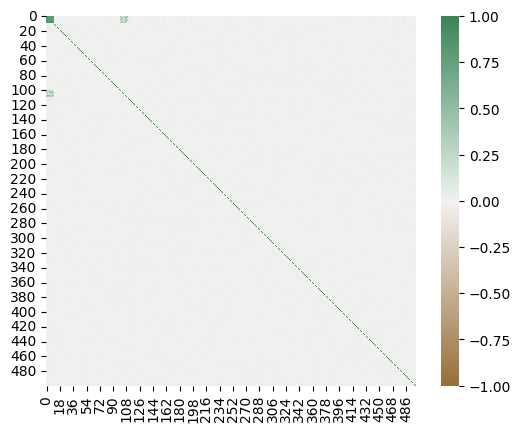

In [57]:
sns.heatmap(corr_matrix,
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True)
plt.savefig("img/correlation_matrix_all.png", dpi=400)
plt.show()

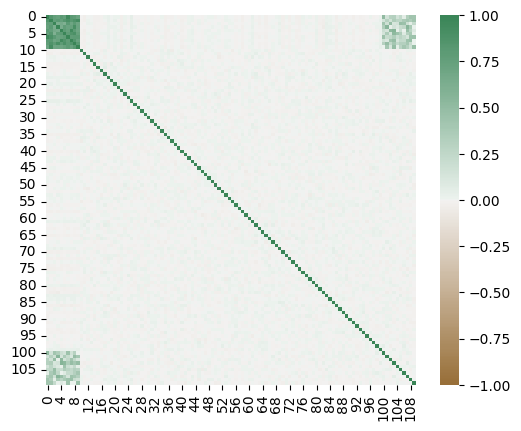

In [58]:
sns.heatmap(corr_matrix.iloc[:110,:110],
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True)
plt.show()

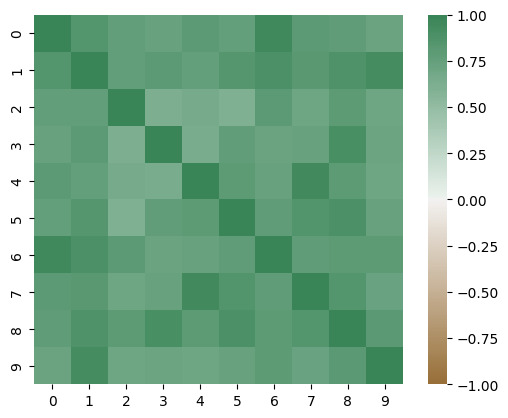

In [59]:
sns.heatmap(corr_matrix.iloc[:10,:10],
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True)
plt.savefig("img/correlation_matrix_high_corr.png", dpi=400)
plt.show()

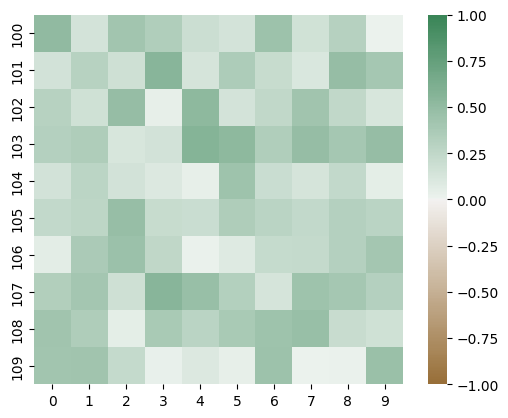

In [60]:
sns.heatmap(corr_matrix.iloc[100:110,:10],
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(50, 500, n=500),
            square=True)
plt.savefig("img/correlation_matrix_small_corr.png", dpi=400)
plt.show()

In [61]:
_ = remove_collinear_features(X_train, 0.8)

Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


As it can be seen, there are some columns that are highly correlated.

# RFE

## Correlation removed

In [19]:
results_dict = {}

In [21]:
results_dict["rfe_no_corr_ranking"] = []
results_dict["scores_list_xgboost_rfe"] = []
results_dict["scores_list_rf_rfe"] = []
results_dict["features_sorted_rf_rfe"] = []

for i in tqdm(range(5)):
    X_train,X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_train_no_corr = remove_collinear_features(X_train, 0.8)
    X_val_no_corr = X_val.loc[:,X_train_no_corr.columns]

    model_selection = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=2)
    selector_rfe = RFE(model_selection, n_features_to_select=1, step=1, verbose=0)
    selector_rfe.fit(X_train_no_corr, y_train)
    results_dict["rfe_no_corr_ranking"].append(selector_rfe.ranking_)

    n_features_list = [x for x in range(1, 21, 1)]
    model_xgboost =  xgb.XGBClassifier(n_estimators=100, n_jobs=-1, max_depth=2, random_state=0)
    model_rf =  RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)

    scores_xgboost = np.array(prepare_scores_data(model_xgboost, n_features_list, X_train_no_corr, y_train, X_val_no_corr, y_val, results_dict["rfe_no_corr_ranking"][i]))
    scores_rf = np.array(prepare_scores_data(model_rf, n_features_list, X_train_no_corr, y_train, X_val_no_corr,  y_val, results_dict["rfe_no_corr_ranking"][i]))

    results_dict["scores_list_xgboost_rfe"].append(scores_xgboost)
    results_dict["scores_list_rf_rfe"].append(scores_rf)
    
    key = "rfe_no_corr_ranking"
    df = X_train_no_corr
    max_features = 20
    order = np.argsort(results_dict[key][i][results_dict[key][i] <= max_features])
    col_names = np.array(df.iloc[:,np.argwhere(results_dict[key][i] <= max_features).flatten()].columns)
    print(col_names[order])
    results_dict["features_sorted_rf_rfe"].append(np.array(col_names[order]))

  0%|          | 0/5 [00:00<?, ?it/s]

Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 20%|██        | 1/5 [02:34<10:16, 154.24s/it]

['105' '100' '102' '101' '103' '104' '0' '2' '74' '63' '357' '300' '40'
 '82' '57' '38' '119' '133' '325' '42']
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 40%|████      | 2/5 [05:04<07:36, 152.06s/it]

['101' '102' '100' '105' '103' '104' '2' '0' '60' '39' '21' '328' '74'
 '323' '316' '303' '38' '357' '339' '302']
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 60%|██████    | 3/5 [07:37<05:04, 152.21s/it]

['105' '102' '100' '101' '103' '104' '0' '328' '2' '75' '316' '323' '322'
 '26' '295' '335' '360' '119' '106' '351']
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 80%|████████  | 4/5 [10:10<02:32, 152.61s/it]

['102' '105' '103' '100' '101' '104' '0' '2' '60' '64' '155' '106' '35'
 '36' '20' '44' '324' '336' '360' '295']
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


100%|██████████| 5/5 [12:48<00:00, 153.72s/it]

['105' '102' '100' '103' '101' '104' '2' '0' '323' '155' '60' '322' '131'
 '337' '50' '342' '285' '44' '291' '32']


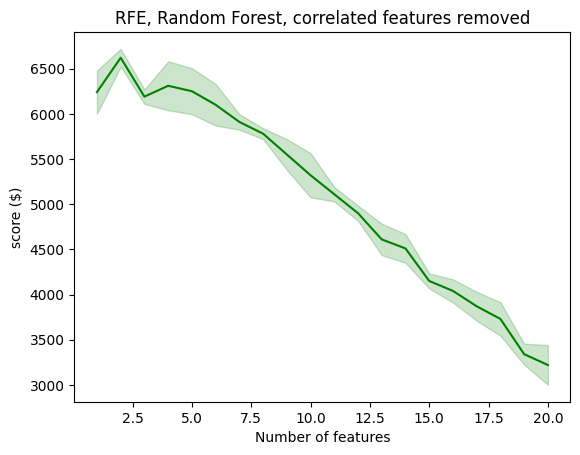

In [142]:
means = np.mean(results_dict["scores_list_rf_rfe"], axis=0)
std = np.std(results_dict["scores_list_rf_rfe"], axis=0)
results_dict["scores_list_rf_rfe_means"] = means
results_dict["scores_list_rf_rfe_std"] = std
plot_scores_2(n_features_list, means, std, color="green", plot_title="RFE, Random Forest, correlated features removed")

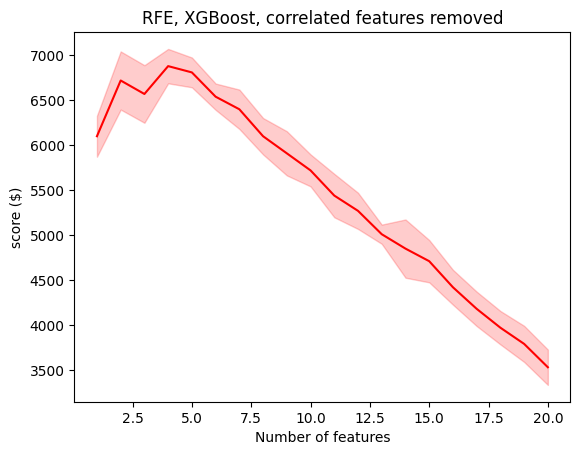

In [143]:
means = np.mean(results_dict["scores_list_xgboost_rfe"], axis=0)
std = np.std(results_dict["scores_list_xgboost_rfe"], axis=0)
results_dict["scores_list_xgboost_rfe_means"] = means
results_dict["scores_list_xgboost_rfe_std"] = std
plot_scores_2(n_features_list, means, std, color="red", plot_title="RFE, XGBoost, correlated features removed")

## Correlation not removed

In [25]:
results_dict["rfe_with_corr_ranking"] = []
results_dict["scores_list_xgboost_rfe_with_corr"] = []
results_dict["scores_list_rf_rfe_with_corr"] = []
results_dict["features_sorted_rf_rfe_with_corr"] = []

for i in tqdm(range(5)):
    X_train,X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    model_selection = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=2)
    selector_rfe = RFE(model_selection, n_features_to_select=1, step=1, verbose=0)
    selector_rfe.fit(X_train, y_train)
    results_dict["rfe_with_corr_ranking"].append(selector_rfe.ranking_)

    n_features_list = [x for x in range(1, 21, 1)]
    model_xgboost =  xgb.XGBClassifier(n_estimators=100, n_jobs=-1, max_depth=2, random_state=0)
    model_rf =  RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)

    scores_xgboost = np.array(prepare_scores_data(model_xgboost, n_features_list, X_train, y_train, X_val, y_val, results_dict["rfe_with_corr_ranking"][i]))
    scores_rf = np.array(prepare_scores_data(model_rf, n_features_list, X_train, y_train, X_val,  y_val, results_dict["rfe_with_corr_ranking"][i]))

    results_dict["scores_list_xgboost_rfe_with_corr"].append(scores_xgboost)
    results_dict["scores_list_rf_rfe_with_corr"].append(scores_rf)
    
    key = "rfe_with_corr_ranking"
    df = X_train
    max_features = 20
    order = np.argsort(results_dict[key][i][results_dict[key][i] <= max_features])
    col_names = np.array(df.iloc[:,np.argwhere(results_dict[key][i] <= max_features).flatten()].columns)
    print(f"Sorted features by importance: {col_names[order]}")
    print("--------------------------------------------------------")
    results_dict["features_sorted_rf_rfe_with_corr"].append(np.array(col_names[order]))

 20%|██        | 1/5 [02:32<10:10, 152.71s/it]

Sorted features by importance: ['100' '105' '102' '8' '101' '104' '103' '5' '2' '3' '6' '1' '9' '4' '35'
 '133' '7' '300' '316' '307']
--------------------------------------------------------


 40%|████      | 2/5 [05:00<07:29, 149.82s/it]

Sorted features by importance: ['105' '100' '102' '8' '101' '103' '1' '104' '5' '6' '7' '3' '4' '0' '9'
 '2' '295' '325' '311' '285']
--------------------------------------------------------


 60%|██████    | 3/5 [07:28<04:57, 148.89s/it]

Sorted features by importance: ['102' '100' '105' '8' '101' '103' '104' '5' '3' '9' '6' '2' '7' '1' '4'
 '355' '294' '302' '29' '316']
--------------------------------------------------------


 80%|████████  | 4/5 [09:56<02:28, 148.57s/it]

Sorted features by importance: ['102' '105' '100' '103' '101' '104' '8' '6' '0' '5' '9' '3' '2' '7' '1'
 '4' '32' '328' '316' '331']
--------------------------------------------------------


100%|██████████| 5/5 [12:23<00:00, 148.78s/it]

Sorted features by importance: ['100' '102' '105' '8' '103' '101' '104' '6' '3' '0' '2' '5' '4' '7' '9'
 '328' '337' '49' '352' '14']
--------------------------------------------------------


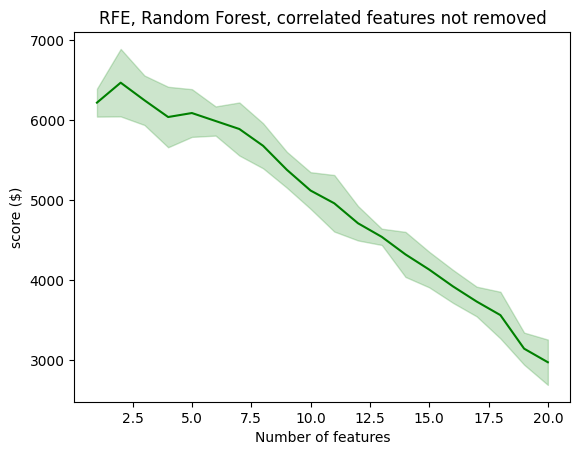

In [144]:
means = np.mean(results_dict["scores_list_rf_rfe_with_corr"], axis=0)
std = np.std(results_dict["scores_list_rf_rfe_with_corr"], axis=0)
results_dict["scores_list_rf_rfe_with_corr_means"] = means
results_dict["scores_list_rf_rfe_with_corr_std"] = std
plot_scores_2(n_features_list, means, std, color="green", plot_title="RFE, Random Forest, correlated features not removed")

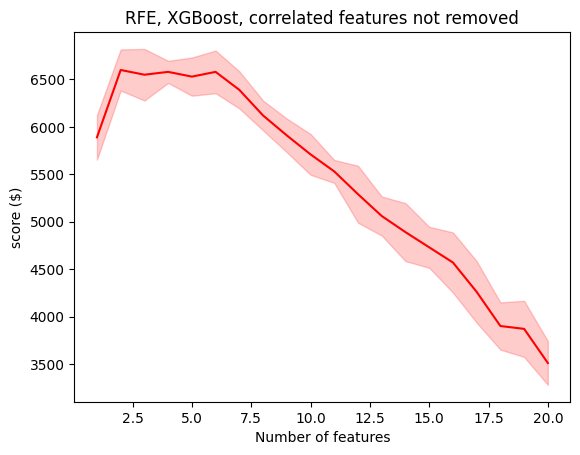

In [145]:
means = np.mean(results_dict["scores_list_xgboost_rfe_with_corr"], axis=0)
std = np.std(results_dict["scores_list_xgboost_rfe_with_corr"], axis=0)
results_dict["scores_list_xgboost_rfe_with_corr_means"] = means
results_dict["scores_list_xgboost_rfe_with_corr_std"] = std
plot_scores_2(n_features_list, means, std, color="red", plot_title="RFE, XGBoost, correlated features not removed")

# Select k best

## Correlation removed

In [29]:
results_dict["select_k_best_ranking_no_corr"] = []
results_dict["scores_list_xgboost_select_k_best_no_corr"] = []
results_dict["scores_list_rf_select_k_best_no_corr"] = []
results_dict["features_sorted_rf_select_k_best_no_corr"] = []

for i in tqdm(range(5)):
    X_train,X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    X_train_no_corr = remove_collinear_features(X_train, 0.8)
    X_val_no_corr = X_val.loc[:,X_train_no_corr.columns]

    selector_k_best = SelectKBest(f_classif, k=1)
    selector_k_best.fit(X_train_no_corr, y_train)
    ranks_k_best = get_ranks_from_scores(scores=selector_k_best.scores_, best='max')
    results_dict["select_k_best_ranking_no_corr"].append(ranks_k_best)

    n_features_list = [x for x in range(1, 21, 1)]
    model_xgboost =  xgb.XGBClassifier(n_estimators=100, n_jobs=-1, max_depth=2, random_state=0)
    model_rf =  RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1, random_state=0)

    scores_list_xgboost_k_best_no_corr = prepare_scores_data(model_xgboost,
                                                    n_features_list,
                                                    X_train_no_corr,
                                                    y_train,
                                                    X_val_no_corr,
                                                    y_val,
                                                    ranks_k_best)
    scores_list_rf_k_best_no_corr = prepare_scores_data(model_rf,
                                                n_features_list,
                                                X_train_no_corr,
                                                y_train,
                                                X_val_no_corr,
                                                y_val,
                                                ranks_k_best)

    results_dict["scores_list_xgboost_select_k_best_no_corr"].append(scores_list_xgboost_k_best_no_corr)
    results_dict["scores_list_rf_select_k_best_no_corr"].append(scores_list_rf_k_best_no_corr)

    key = "select_k_best_ranking_no_corr"
    df = X_train_no_corr
    max_features = 20
    order = np.argsort(results_dict[key][i][results_dict[key][i] <= max_features])
    col_names = np.array(df.iloc[:,np.argwhere(results_dict[key][i] <= max_features).flatten()].columns)
    print(f"Sorted features by importance: {col_names[order]}")
    print("--------------------------------------------------------")
    results_dict["features_sorted_rf_select_k_best_no_corr"].append(np.array(col_names[order]))

  0%|          | 0/5 [00:00<?, ?it/s]

Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 20%|██        | 1/5 [00:09<00:38,  9.66s/it]

Sorted features by importance: ['403' '323' '155' '328' '466' '285' '458' '98' '35' '64' '138' '77' '303'
 '471' '321' '189' '198' '21' '306' '220']
--------------------------------------------------------
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 40%|████      | 2/5 [00:18<00:28,  9.42s/it]

Sorted features by importance: ['220' '403' '155' '35' '273' '64' '171' '285' '321' '148' '47' '458'
 '335' '21' '266' '252' '79' '204' '80' '75']
--------------------------------------------------------
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 60%|██████    | 3/5 [00:28<00:18,  9.42s/it]

Sorted features by importance: ['155' '64' '321' '403' '466' '220' '204' '306' '191' '105' '215' '285'
 '323' '303' '335' '458' '273' '75' '86' '34']
--------------------------------------------------------
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


 80%|████████  | 4/5 [00:37<00:09,  9.31s/it]

Sorted features by importance: ['498' '466' '35' '155' '412' '403' '303' '324' '306' '21' '64' '20' '175'
 '288' '249' '206' '266' '495' '253' '139']
--------------------------------------------------------
Removed columns: ['1', '3', '4', '5', '6', '7', '8', '9']


100%|██████████| 5/5 [00:45<00:00,  9.19s/it]

Sorted features by importance: ['403' '458' '285' '220' '155' '335' '273' '57' '64' '357' '175' '321'
 '29' '303' '323' '35' '73' '266' '203' '466']
--------------------------------------------------------


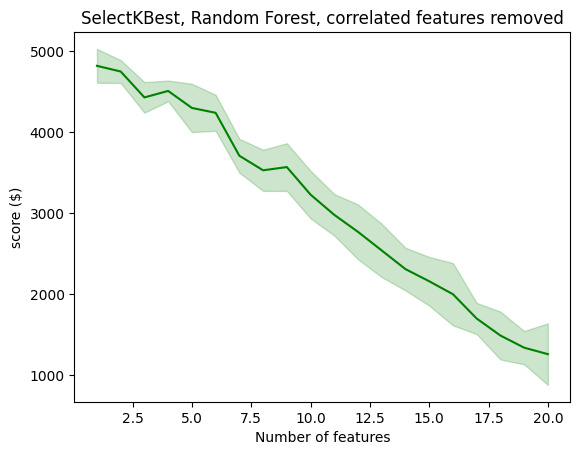

In [138]:
means = np.mean(results_dict["scores_list_rf_select_k_best_no_corr"], axis=0)
std = np.std(results_dict["scores_list_rf_select_k_best_no_corr"], axis=0)
results_dict["scores_list_rf_select_k_best_no_corr_means"] = means
results_dict["scores_list_rf_select_k_best_no_corr_std"] = std
plot_scores_2(n_features_list, means, std, color="green", plot_title="SelectKBest, Random Forest, correlated features removed")

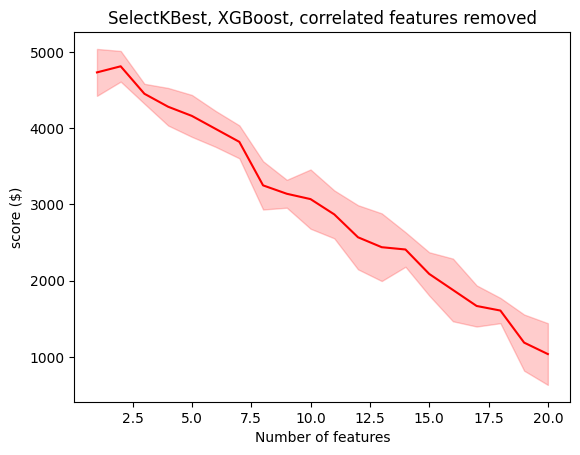

In [139]:
means = np.mean(results_dict["scores_list_xgboost_select_k_best_no_corr"], axis=0)
std = np.std(results_dict["scores_list_xgboost_select_k_best_no_corr"], axis=0)
results_dict["scores_list_xgboost_select_k_best_no_corr_means"] = means
results_dict["scores_list_xgboost_select_k_best_no_corr_std"] = std
plot_scores_2(n_features_list, means, std, color="red", plot_title="SelectKBest, XGBoost, correlated features removed")

## Correlation not removed

In [32]:
results_dict["select_k_best_ranking_with_corr"] = []
results_dict["scores_list_xgboost_select_k_best_with_corr"] = []
results_dict["scores_list_rf_select_k_best_with_corr"] = []
results_dict["features_sorted_rf_select_k_best_with_corr"] = []

for i in tqdm(range(5)):
    X_train,X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    selector_k_best = SelectKBest(f_classif, k=1)
    selector_k_best.fit(X_train_no_corr, y_train)
    ranks_k_best = get_ranks_from_scores(scores=selector_k_best.scores_, best='max')
    results_dict["select_k_best_ranking_with_corr"].append(ranks_k_best)

    n_features_list = [x for x in range(1, 21, 1)]
    model_xgboost =  xgb.XGBClassifier(n_estimators=100, n_jobs=-1, max_depth=2, random_state=0)
    model_rf =  RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1, random_state=0)

    scores_list_xgboost_k_best_with_corr = prepare_scores_data(model_xgboost,
                                                    n_features_list,
                                                    X_train,
                                                    y_train,
                                                    X_val,
                                                    y_val,
                                                    ranks_k_best)
    scores_list_rf_k_best_with_corr = prepare_scores_data(model_rf,
                                                n_features_list,
                                                X_train,
                                                y_train,
                                                X_val,
                                                y_val,
                                                ranks_k_best)

    results_dict["scores_list_xgboost_select_k_best_with_corr"].append(scores_list_xgboost_k_best_with_corr)
    results_dict["scores_list_rf_select_k_best_with_corr"].append(scores_list_rf_k_best_with_corr)

    key = "select_k_best_ranking_with_corr"
    df = X_train_no_corr
    max_features = 20
    order = np.argsort(results_dict[key][i][results_dict[key][i] <= max_features])
    col_names = np.array(df.iloc[:,np.argwhere(results_dict[key][i] <= max_features).flatten()].columns)
    print(f"Sorted features by importance: {col_names[order]}")
    print("--------------------------------------------------------")
    results_dict["features_sorted_rf_select_k_best_with_corr"].append(np.array(col_names[order]))

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:07<00:29,  7.40s/it]

Sorted features by importance: ['327' '435' '398' '275' '125' '368' '184' '205' '271' '479' '325' '456'
 '406' '55' '439' '226' '98' '48' '317' '61']
--------------------------------------------------------


 40%|████      | 2/5 [00:14<00:20,  6.95s/it]

Sorted features by importance: ['334' '400' '165' '369' '230' '439' '322' '324' '280' '333' '0' '365'
 '413' '256' '428' '2' '422' '417' '146' '359']
--------------------------------------------------------


 60%|██████    | 3/5 [00:22<00:15,  7.53s/it]

Sorted features by importance: ['288' '109' '301' '91' '0' '226' '2' '371' '220' '425' '263' '485' '225'
 '488' '228' '216' '157' '420' '130' '294']
--------------------------------------------------------


 80%|████████  | 4/5 [00:28<00:07,  7.06s/it]

Sorted features by importance: ['335' '45' '101' '316' '70' '11' '46' '310' '308' '203' '193' '84' '184'
 '358' '496' '439' '13' '433' '256' '391']
--------------------------------------------------------


100%|██████████| 5/5 [00:35<00:00,  7.00s/it]

Sorted features by importance: ['191' '305' '124' '406' '27' '378' '244' '306' '234' '208' '142' '284'
 '118' '199' '150' '374' '176' '473' '439' '269']
--------------------------------------------------------


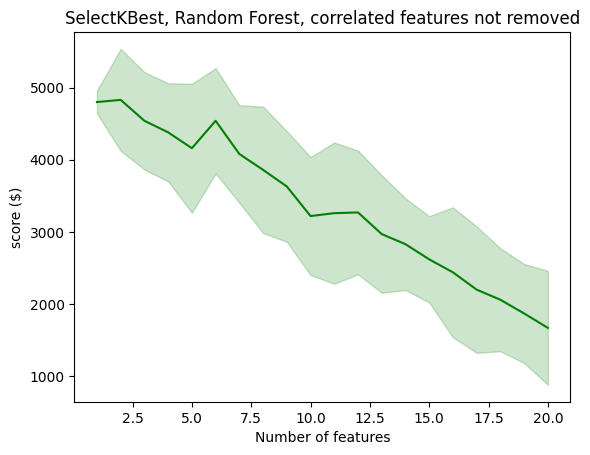

In [140]:
means = np.mean(results_dict["scores_list_rf_select_k_best_with_corr"], axis=0)
std = np.std(results_dict["scores_list_rf_select_k_best_with_corr"], axis=0)
results_dict["scores_list_rf_select_k_best_with_corr_means"] = means
results_dict["scores_list_rf_select_k_best_with_corr_std"] = std
plot_scores_2(n_features_list, means, std, color="green", plot_title="SelectKBest, Random Forest, correlated features not removed")

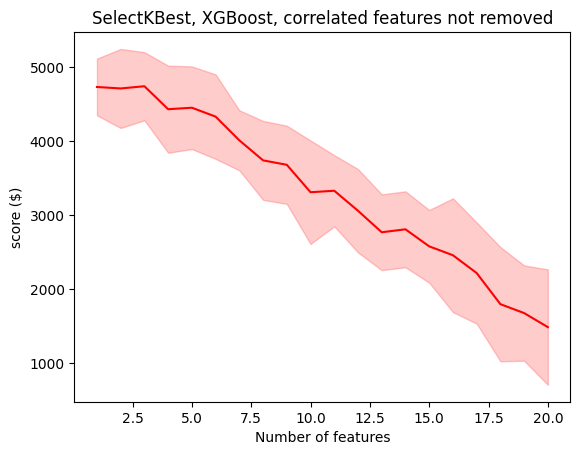

In [141]:
means = np.mean(results_dict["scores_list_xgboost_select_k_best_with_corr"], axis=0)
std = np.std(results_dict["scores_list_xgboost_select_k_best_with_corr"], axis=0)
results_dict["scores_list_xgboost_select_k_best_with_corr_means"] = means
results_dict["scores_list_xgboost_select_k_best_with_corr_std"] = std
plot_scores_2(n_features_list, means, std, color="red", plot_title="SelectKBest, XGBoost, correlated features not removed")

# Saving results

In [35]:
with open('results_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

# Fitting best model

Chosen features: 105, 100, 102, 101

Chosem model: XGBoost

In [83]:
model_final =  xgb.XGBClassifier(n_estimators=100, n_jobs=-1, max_depth=2, random_state=0)

In [84]:
X = pd.read_csv(os.path.join(DATA_DIR, 'x_train.txt'), sep=" ", header=None)
X.columns = X.columns.astype(str)
X_test = pd.read_csv(os.path.join(DATA_DIR, 'x_test.txt'), sep=" ", header=None)
X_test.columns = X_test.columns.astype(str)
y = np.array(pd.read_csv(os.path.join(DATA_DIR, 'y_train.txt'), header=None)[0])

In [135]:
X_train_final = X.loc[:,np.array(["105", "100", "102", "101"])]

In [87]:
model_final.fit(X_train_final, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [134]:
X_test_final = X_test.loc[:,np.array(["105", "100", "102", "101"])]

In [106]:
y_proba = model_final.predict_proba(X_test_final)

In [104]:
top_probas = np.argpartition(y_proba[:,1], -1000)[-1000:]+1

In [132]:
file = open('313315_obs.txt','w')
for item in top_probas.tolist():
	file.write(str(item)+"\n")
file.close()

In [133]:
file = open('313315_vars.txt','w')
for item in [106, 101, 103, 102]:
	file.write(str(item)+"\n")
file.close()